## HoltWinters for Forecasting

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
#to use statsmodel on this dataset, set index.freq = monthly freq, as data has timestamp of each month's 1st day.

df.index.freq = 'MS'

In [4]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [5]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [6]:
df.tail()

,Thousands of Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [7]:
#so 1961 is the future that we can forecast here, coz we dont havve data for it

<br>

## TEST TRAIN SPLIT

* in time series, test data will be the MOST RECENT split of the data in time.

remember we've target values for both train and test sets!

> fit model on TRAINING data
> use that model to forecast TEST data
> compare Forecasted vs Actual Values coz we already know the correct ans for the test data
> calculate the Evaluation Metric


ques : how to decide how much data should be test data ?

no correct ans here. <br>
Typically, Test data = 20 % of Training data. <br>

But generally it DEPENDS on : 
 1. the length of the entire Time-Series we're using.
 2. how far ahead into future you want to forecast. <i> test set should atleast be equal to the <b>max. forecast horizon.
    
for eg : to forecast 1 month into the future, use 1 mnth data as test set and rest as training data
    
> remember, LONGER FORECAST HORIZON => LESS Accurate Predictions

train-test-split is an INDEXING command so you can do it by using :
1. timestamp 
2. integer index locations



In [30]:
df.info()

train_data = df.iloc[ : 109] #.loc[ : '1940-04-01']

test_data = df.iloc[108 : ]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
Thousands of Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


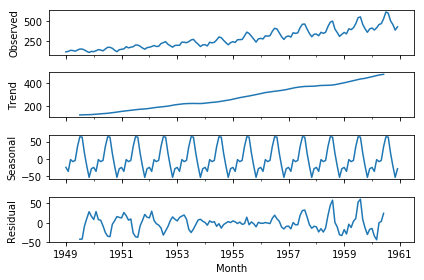

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df['Thousands of Passengers']).plot();

In [32]:
#now fit the model

from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_data.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [33]:
model = ExponentialSmoothing(train_data['Thousands of Passengers'], trend='mul', seasonal = 'mul', seasonal_periods=12)

In [34]:
fitted_model = model.fit()

In [35]:
#now use the fitted_model on test-data for forecasting

test_predictions = fitted_model.forecast(steps = 36)

#forecasting 36 months into the future here

In [36]:
# predicted values

test_predictions.head()

1958-02-01    331.649486
1958-03-01    388.989620
1958-04-01    380.125229
1958-05-01    388.290918
1958-06-01    453.379217
Freq: MS, dtype: float64

In [37]:
# actual values

test_data.head()

,Thousands of Passengers
Month,
1958-01-01,340
1958-02-01,318
1958-03-01,362
1958-04-01,348
1958-05-01,363


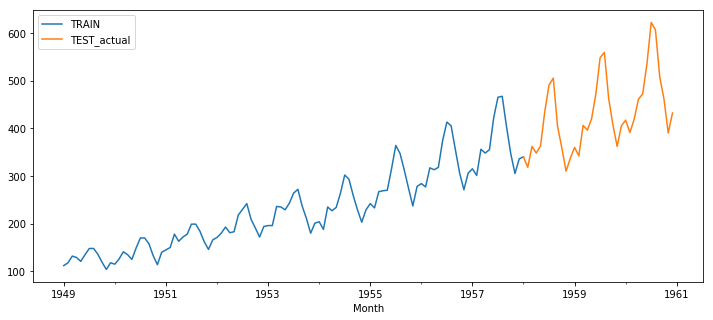

In [38]:
# plotting REAL DATA

train_data['Thousands of Passengers'].plot(legend=True, label='TRAIN', figsize=(12,5));

test_data['Thousands of Passengers'].plot(legend=True, label='TEST_actual');

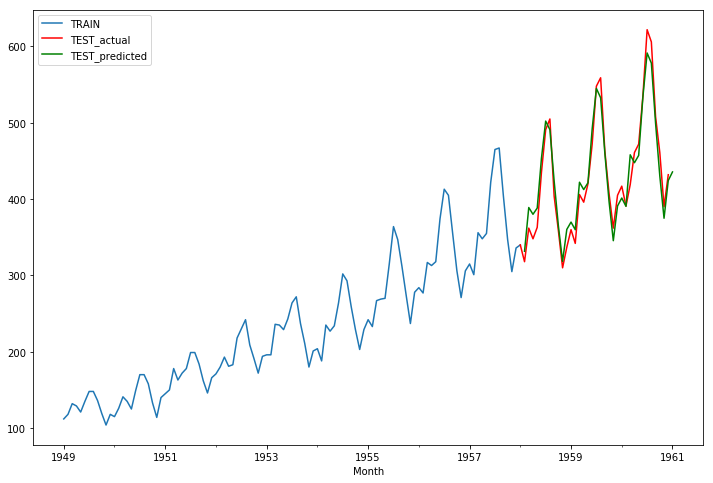

In [39]:
# plotting real vs predicted values

train_data['Thousands of Passengers'].plot(legend=True, label='TRAIN', figsize=(12,8));

test_data['Thousands of Passengers'].plot(legend=True, label='TEST_actual', color='red');

test_predictions.plot(legend=True, label='TEST_predicted', color='green');

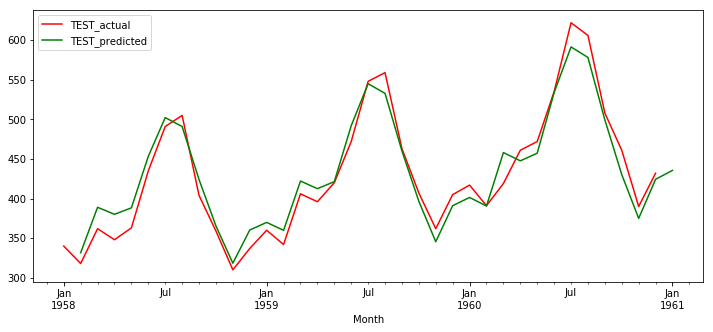

In [40]:
test_data['Thousands of Passengers'].plot(legend=True, label='TEST_actual', color='red', figsize=(12,5));

test_predictions.plot(legend=True, label='TEST_predicted', color='green');

we can see we're picking the sesonality quite well. but the predictions are not accurate. somewhere they're lagging or they're over-predicting.

for a simple model we're using, this is doing pretty good.

-------------------------------------------------------------------------------------------------------------------------

### QUANTIFYING model performance using Evaluation Metrics

Evaluation metrics :

help to quantify the difference between actual and predicted values, rather than just visually seeing how off it is. 

eg : accuracy , recall , precision  >>>>>>> these are used for error prediction in CLASSIFICATION Problems where Categories are predicted

But these are not useful for TSA.

<br>

<b> we need metrics designed for CONTINUOUS VALUES </b>

> therefore, metrics for TIME-SERIES and REGRESSION are the same, <i> as they both predict Continuous Values </i>

Commons metrics for REGRESSION & TSA :
1. Mean Absolute error
2. Mean Squared error
3. Root Mean Square error

So Forecasting a Continuous value for a Test-set, we've :
* y - real value of test data
* y^ - predicted value of test data  (y cap)

#### Mean Absolute error

> its the MEAN of the ABSOLUTE VALUE of ERRORS, where error = diff in y and y^

easy to understand
<br>

<u> what we're doing here?</u> :

1. for every row in our test-dataset, we're differencing true-value & predicted value. 

2. then, we're taking abs() of that value, ie we're removing sign (+-) , coz <i> we need to sum and calc net error but if negatives cancel out positive, net error will come put to less than it actually is. so we make all the values positive so that their summation becomes meaningful. coz doesn't matter y^ is more or less, if its different than y, it means its an error and it has to be ADDED </i>

3. finally that sum of errors is divided by the no. of rows in test-data to get the mean error.

<br>

<u> issues with MAE </u> :
* its just simple averaging so it won't alert if the forecast was actually off for just a few points and okay for rest all. eg : there might be a few very large errors and rest all on-point but MAE will give an average supposedly spread out across all the predictions, which is not meaningful.


<br>

#### Mean Squared error

> its the MEAN of SUM of (SQUARE of ERRORS) ie (y - y^)**2

better than MAE, as MSE tells abt large errors better.

<br>

<u>what you're doing here? </u>:
1. for each test-data row, taking difference of y and y^
2. squaring each difference
3. adding those squares
4. dividing the final sum by the no. of values in test-data.

<u>why is MSE better than MAE? </u> :
1. as we're squaring, the problem of having negative terms in error summation is solved.
2. larger errors are going to be registered more here coz a residual of 20 becomes 400 on squaring <i> so here you're punishing the model more for large errors which is imp for forecasting.</i>
    

<u> issues with MSE </u>:
* the dimensions of MSE are also the (square of test-data dimension), <b> which is hard to interpret wrt data </b><br>
eg : if you're predicting sales in dollar-units, MSE will evaluate & return error in units of (dollars)squared.
    

<br>

#### Root Mean Square error

> RMS error = square root of (MSE)

<b> rms has same units/dimensions as our individual target data </b>
<br>
<u>what we're doing?</u>:
1. calc final value of MSE same as above
2. take root that MSE

<br>
this is basically the same diff as there is b/w StandardDeviation & Variation. SD = root of (VAR)
<br>
<br>
<u>"what is an acceptable RMSE value?"</u>:<br>
> ans depends on data being used. <br>
for eg : if i say you're off by an RMSE value of 20-USD, then if your dataset is houses-sale data, this error is not big wrt thousands & millions of dolloar costs. But if its skincare-products' prices data, then 20-USD error can be huge in predictions.

> so you can try comparing (RMSe-value) with (Avg of Target Values in test-data for which RMS was calculated), then use your judgement.<br> 
eg: by comparing RMS of USD- 2 against theordinary's avg pricing to see if USD-2 matters or not? PS: itdoes!

<b>so here, we've evaluated our test-set predictions! BUT how to EVALUATE future predictions we're making, for the ones we don't have an actual value yet?</b>

> you just cant !! <br>

coz there's no way to evaluate predicted-values for which we dont have the corresponding true-values.

>thats why TEST-TRAIN split is so imprtant ! <i> coz it shows how well your model performs on the DATA IT HASN'T SEEN YET </i>

### coding EM

In [41]:
from sklearn.metrics import mean_squared_error , mean_absolute_error

In [42]:
mean_absolute_error(test_data, test_predictions)

46.30290453876919

In [43]:
# compare MAE with AVG VALUE OF TEST DATA'S TARGET VAR

test_data.describe()

,Thousands of Passengers
count,36.000000
mean,428.500000
std,79.329152
min,310.000000
25%,362.000000
50%,412.000000
75%,472.000000
max,622.000000


In [46]:
# mse

mean_squared_error(test_data, test_predictions)

# compare with VARIANCE of testdata's target but not v useful value 

3075.328464707026

In [47]:
#rms using mse

np.sqrt(mean_squared_error(test_data, test_predictions))

55.45564411948549

In [48]:
# rms can be compared to STD DEV of Target Variable of Test Data

as  both rms and mae are less than their respective comparisons, the model is performing quite well, as we can see from the graph its not too off.

> now we're satisfied by the model's performance, lets fit it again on the entire dataset and use to predict actual future that hasn't happened yet and we've no known target values.

In [51]:
final_model = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul', seasonal='mul', seasonal_periods=12)

In [52]:
final_fitted_model = final_model.fit()

In [54]:
#forecast

forecast_preds = final_fitted_model.forecast(steps=36)

#forecasting 36 months forward

forecast_preds.head()

1961-01-01    450.696219
1961-02-01    424.853976
1961-03-01    475.608791
1961-04-01    504.080734
1961-05-01    517.915698
Freq: MS, dtype: float64

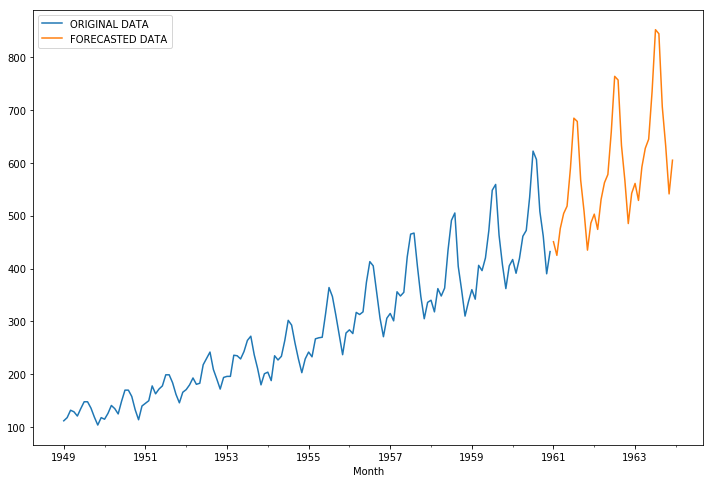

In [56]:
#plot original data df vs the forecasted preds

df['Thousands of Passengers'].plot(legend=True, label='ORIGINAL DATA', figsize=(12,8));

forecast_preds.plot(legend=True, label='FORECASTED DATA');

So we can see the trend is growing as required and we also have the seasonality captured. 

In [57]:
pwd

'C:\\Users\\Sneha\\mywork\\tsa_cou_fol'

In [60]:
df2 = pd.read_csv('Data/samples.csv', index_col=0, parse_dates=True)

In [61]:
df2.head()

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


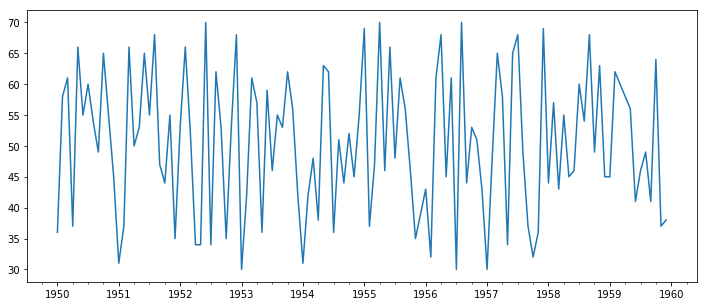

In [63]:
df2['a'].plot(figsize=(12,5))

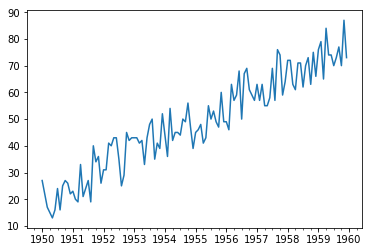

In [65]:
df2.b.plot();

In [66]:
from statsmodels.tsa.statespace.tools import diff

In [70]:
df2.b - df2['b'].shift(1)

1950-01-01     NaN
1950-02-01    -5.0
1950-03-01    -5.0
1950-04-01    -2.0
1950-05-01    -2.0
1950-06-01     3.0
1950-07-01     8.0
1950-08-01    -8.0
1950-09-01     9.0
1950-10-01     2.0
1950-11-01    -1.0
1950-12-01    -4.0
1951-01-01     1.0
1951-02-01    -3.0
1951-03-01    -1.0
1951-04-01    14.0
1951-05-01   -12.0
1951-06-01     3.0
1951-07-01     3.0
1951-08-01    -8.0
1951-09-01    21.0
1951-10-01    -6.0
1951-11-01     2.0
1951-12-01   -10.0
1952-01-01     5.0
1952-02-01     0.0
1952-03-01    10.0
1952-04-01    -1.0
1952-05-01     3.0
1952-06-01     0.0
              ... 
1957-07-01    11.0
1957-08-01   -12.0
1957-09-01    19.0
1957-10-01    -2.0
1957-11-01   -15.0
1957-12-01     5.0
1958-01-01     8.0
1958-02-01     0.0
1958-03-01    -9.0
1958-04-01    -2.0
1958-05-01    10.0
1958-06-01     0.0
1958-07-01    -9.0
1958-08-01     8.0
1958-09-01     3.0
1958-10-01   -10.0
1958-11-01    12.0
1958-12-01    -9.0
1959-01-01    10.0
1959-02-01     3.0
1959-03-01   -14.0
1959-04-01  

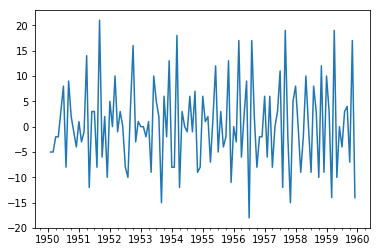

In [75]:
#do this directly using diff()

diff( df2['b'], k_diff=1 ).plot();